Given an excel sheet of order data (with orderdate, orderstatus, return date and number of orders) names `biz_orders.xlsx`, we will attempt to find the return rate on these orders

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read excel file and store as dataframe
df = pd.read_excel('biz_orders.xlsx')

The excel sheet looks something like:

In [4]:
df.head()

,dateordered,datereturned,orderstatus,orders
0,2016-12-31,2017-01-24,returned,1
1,2016-12-31,NaT,complete,8
2,2016-12-30,NaT,complete,14
3,2016-12-29,NaT,complete,14
4,2016-12-28,2016-12-29,returned,1


We can see in the Excel sheet that most returned orders seem to be only 1 in quantity (per date). Let's see if our hypothesis is correct by grouping all orders by the quantity of `orders`.

In [5]:
by_orders = df.groupby([df['orders']]).count()
by_orders

,dateordered,datereturned,orderstatus
orders,,,
1,66,60,66
2,13,0,13
3,17,0,17
4,16,0,16
5,18,0,18
6,22,0,22
7,12,0,12
8,12,0,12
9,7,0,7


Indeed, our hypothesis was correct and we can see that all 60 of the data under `datereturned` column, i.e. returned items, are categorized to `orders` of quantity 1. This insight will make it easier to manipulate our data since we only have to account once for returned orders.

Now, since we want to find the monthly return rate of orders, we can group by the month and `orderstatus` to see how many orders were returned or completed each month.

In [6]:
by_month_order = df.groupby([df['dateordered'].dt.month,df['orderstatus'],df['orders']]).count()

# freq_per_month column is the number of times a particular order quanity appears in a month
by_month_order.rename(columns={'dateordered': 'freq_per_month'}, inplace = True)
by_month_order

freq_per_month  datereturned
dateordered orderstatus orders                              
8           complete    1                    3             0
                        2                    1             0
                        3                    8             0
                        4                    7             0
                        5                    4             0
                        6                    5             0
                        7                    1             0
                        8                    2             0
                        9                    1             0
            returned    1                   10            10
9           complete    1                    2             0
                        2                    6             0
                        3                    5             0
                        4                    4             0
                        5                    4             0
                        6                    3             0
                        7                    2             0
                        8                    1             0
                        9                    1             0
                        10                   2             0
            returned    1                    9             9
10          complete    1                    1             0
                        2                    3             0
                        3                    3             0
                        4                    1             0
                        5                    4             0
                        6                    9             0
                        7                    6             0
                        8                    3             0
                        10                   1             0
            returned    1                   10            10
11          complete    2                    3             0
                        3                    1             0
                        4                    3             0
                        5                    5             0
                        6                    5             0
                        7                    2             0
                        8                    2             0
                        9                    3             0
                        10                   1             0
                        11                   2             0
                        13                   1             0
                        36                   1             0
            returned    1                   12            12
12          complete    4                    1             0
                        5                    1             0
                        7                    1             0
                        8                    4             0
                        9                    2             0
                        10                   3             0
                        11                   3             0
                        12                   3             0
                        13                   4             0
                        14                   4             0
                        15                   2             0
                        18                   1             0
                        23                   1             0
                        32                   1             0
            returned    1                   19            19

To calculate the return rate, we need to find out what share of total monthly orders is comprised of returned orders.
The total per month is simply the number of each **completed** orders times its monthly frequency plus number of returned orders

In other words:

$ return\,rate = \frac{returned\,orders}{\sum_{}^{} (complete\,orders\,*\ \#\,of\,times\,orders\,appears\,in\,a\,month)\,+\,returned\,orders} $

In [7]:
total_completed_orders = []

# use for loop to calculate total_completed_orders for each month
for i in range(8, 13):
    orders = by_month_order['freq_per_month'][i]['complete'].index.values
    freq = by_month_order['freq_per_month'][i]['complete'].values  
    # total complete orders = complete orders * freq
    total_completed_orders = np.append(total_completed_orders, np.sum( orders * freq ))
total_completed_orders = total_completed_orders.astype(np.int64)
total_completed_orders

array([139, 134, 170, 214, 376])

In [8]:
# group orders by month 
by_month = df.groupby([df['dateordered'].dt.month]).count().rename_axis('monthordered')
by_month = by_month.drop(columns=['orderstatus','orders']).rename(columns={'dateordered': 'total', 'datereturned':'returned'})

# create columns for total orders, returned, orders, completed orders, and return rate (in percent)
by_month['complete'] = total_completed_orders
by_month['total'] = by_month.apply(lambda row: row.complete + row.returned, axis=1)
by_month['returnrate'] = by_month.apply(lambda row: (row.returned / row.total)*100, axis=1)
by_month

,total,returned,complete,returnrate
monthordered,,,,
8,149,10,139,6.711409
9,143,9,134,6.293706
10,180,10,170,5.555556
11,226,12,214,5.309735
12,395,19,376,4.810127


Now, we have a nice table displaying our calculated information for each of the 5 months:
the total number of orders, returned orders, completed orders, and return rate. We can now display this data in a line graph that plots return rate against monthly progression.

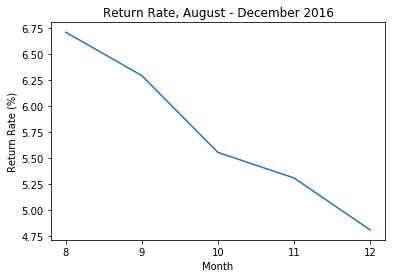

In [9]:
plt.plot(by_month.index, by_month.returnrate)
plt.xticks(np.arange(min(by_month.index), max(by_month.index)+1, 1.0))
plt.xlabel('Month')
plt.ylabel('Return Rate (%)')
plt.title('Return Rate, August - December 2016')
plt.show()

Overall, we see that our return rate is decreasing as we move from August to December. Moreover, the return rate decreased the fastest from September to October.

#### Additional Insights
We can actually visualize how our orders break down by each month, as shown below with a pie chart. As expected, December makes up the plularity of the total orders.

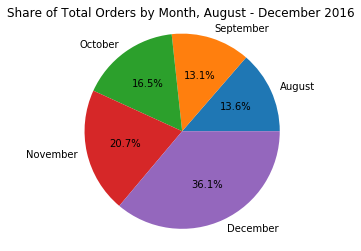

In [10]:
labels = 'August','September','October','November','December'
sizes = [by_month['total'][8], 
         by_month['total'][9],
         by_month['total'][10],
         by_month['total'][11],
         by_month['total'][12]
        ]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Share of Total Orders by Month, August - December 2016')
plt.show()

Another interesting insight is to consider what percentage of total orders were returned from August to December of 2016. Only about 5% of total orders were returned during this time, as shown below.

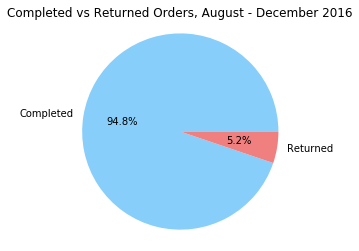

In [11]:
labels = 'Completed','Returned'
sizes = [by_month['total'].sum(), by_month['returned'].sum()]
colors = ['lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Completed vs Returned Orders, August - December 2016')
plt.axis('equal')
plt.show()

My final insight from our data is to understand, on average, how many days it takes for a customer to return an order.

**NOTE:** I'm getting a warning by Pandas with regards to copying the dataframe's column values, but have not been able to make this warning go away. Regardless, the code still works and the calculated data is accurate.

In [12]:
returned_orders = df[df['orderstatus']=='returned'] 
returned_orders['days_till_return'] = (df['datereturned'] - df['dateordered']).dt.days
returned_orders['days_till_return'] = returned_orders['days_till_return'].astype(int)
returned_orders = returned_orders.groupby([df['dateordered'].dt.month]).mean().drop(['orders'], axis=1)
returned_orders

/Users/sunkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sunkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,days_till_return
dateordered,
8,72.700000
9,59.444444
10,47.600000
11,31.083333
12,17.842105


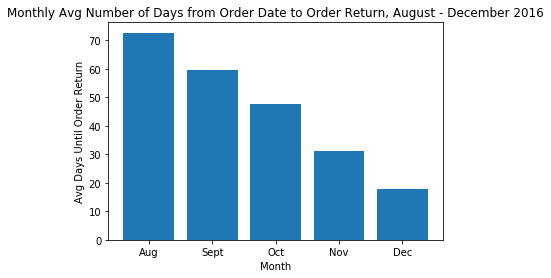

In [13]:
x = np.arange(5)
plt.bar(x, returned_orders['days_till_return'])
plt.xticks(x, ('Aug', 'Sept', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.ylabel('Avg Days Until Order Return')
plt.title('Monthly Avg Number of Days from Order Date to Order Return, August - December 2016')
plt.show()

Once we calculate the monthly average number of days it takes for an order to return, we can see that the time between date ordered and date returned decreases significantly August to December.